# Multiple Network Models

To this point in the book, we have studied network models which are relevant for only a single network. What do we do if we have multiple networks?

Remember that a random network is denoted by a boldfaced uppercase $\mathbf A$, and has realizations $A$. When we have multiple networks, we will need to be able to index them individually. For this reason, in this section, we will use the convention that a random network is denoted by a boldfaced uppercase $\mathbf A^{(m)}$, where $m$ tells us which of the collection of networks we are talking about. The capital letter $N$ defines the *total* number of random networks in our collection. When we use the letter $m$ itself, we will typically be referring to an arbitrary random network amongst the collection of random networks, where $m$ beween $1$ and $N$. When we have $N$ total networks, we will write down the entire **collection of random networks** using the notation $\left\{\mathbf A^{(1)}, ..., \mathbf A^{(N)}\right\}$. With what we have learned to date, for a random network $\mathbf A^{(m)}$, we would be able to use a single nework model to describe $\mathbf A^{(m)}$. This means, for instance, if we thought that each network could be represented by an RDPG, that we would have a latent position matrix $X^{(m)}$ to define each of the $m$ networks. In symbols, we would write that each $\mathbf A^{(m)}$ is an $RDPG_n(X^{(m)})$ random nework. What is the problem with this descripion?

Let's think about this with an example. Let's imagine that we have a company with $20$ total employees which is focused on developing software for network machine learning for business uses. $10$ of these employees are company administrative executives, $25$ of these employees are network machine learning experts, and that $10$ of these employees are marketing experts. For each day over the course of a full $30$-day month, we study the emails that go back and forth between the employees in the company. We summarize the emailing habits within the company using a nework, where the nodes of the network are employees, and the edges indicate the emailing behaviors between each pair of employees. An edge is said to exist if the two employees have exchanged an email on that day, and an edge does not exist if the two employees have not exchanged an email on that day. In most companies, it is common for employees in a similar role to tend to work more closely together, so we might expect that there is some level of a community structure to the emailing habits. For instance, if two employees are both network machine learning experts, they might exchange more emails between one another than a machine learning expert and a marketing expert. For the sake of this example, we will assume that the networks are organized such that the first day is a Monday, the second day is a Tuesday, so on and so forth. Let's take a look at an example of some possible realizations of the first $3$ days worth of emails. What we will see below is that all of the random networks appear to have the same community organization, though on Wednesday, we will assume there was an executive board meeting, and in the morning leading up to the board meeting, the executives of the company exchanged more emails than on other days. This is reflected in the fact that there are more emails going back and forth between board members in the network for "Wednesday":

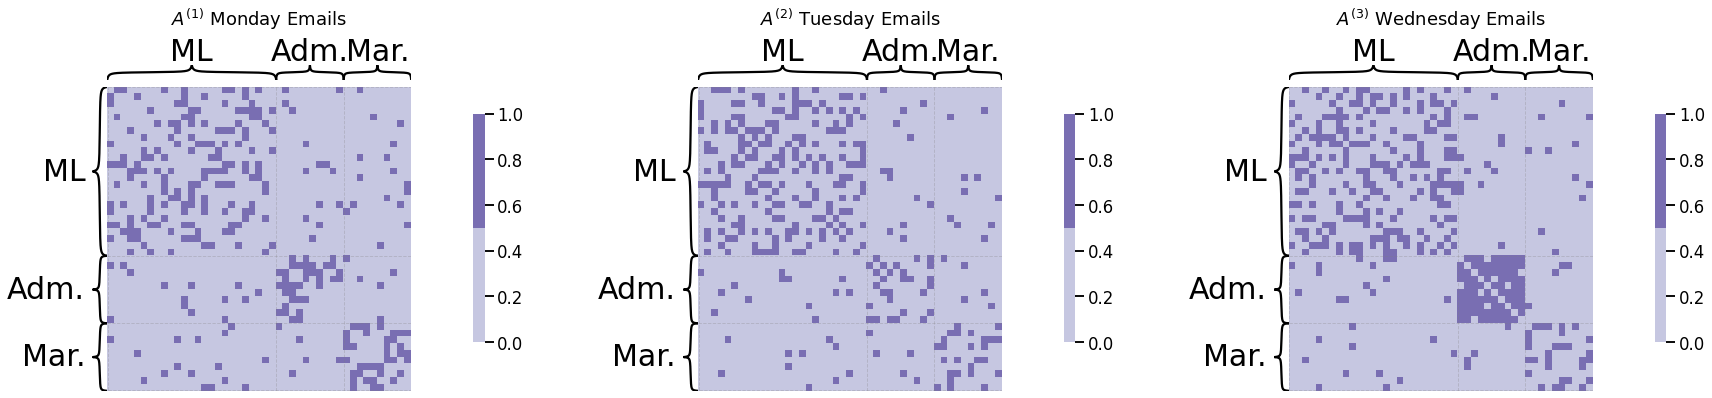

In [43]:
from graphbook_code import heatmap
from graspologic.simulations import sbm
import numpy as np
import matplotlib.pyplot as plt

K = 3

B1 = np.zeros((K,K))

B1[0,0] = 0.3
B1[0,1] = .05
B1[1,0] = .05
B1[0,2] = .05
B1[2,0] = .05
B1[1,1] = 0.3
B1[1,2] = .05
B1[2,1] = .05
B1[2,2] = 0.3

B2 = B1

B3 = np.copy(B1)
B3[1,1] = 0.9

ns = [25, 10, 10]
A1 = sbm(n=ns, p=B1, directed=False, loops=False)
ys = ["ML" for i in range(0, ns[0])] + ["Adm." for i in range(ns[0],ns[0] + ns[1])] + ["Mar." for i in range(ns[0] + ns[1],ns[0] + ns[1] + ns[2])]

A2 = sbm(n=ns, p=B2, directed=False, loops=False)

A3 = sbm(n=ns, p=B3, directed=False, loops=False)

fig, axs = plt.subplots(1,3, figsize=(30, 6))

heatmap(A1, ax=axs[0], title="$A^{(1)}$ Monday Emails", color="sequential", xticklabels=False, yticklabels=False, inner_hier_labels=ys);

heatmap(A2, ax=axs[1], title="$A^{(2)}$ Tuesday Emails", color="sequential", xticklabels=False, yticklabels=False, inner_hier_labels=ys);

heatmap(A3, ax=axs[2], title="$A^{(3)}$ Wednesday Emails", color="sequential", xticklabels=False, yticklabels=False, inner_hier_labels=ys);

If we were to summarize this situation with an RDPG, we might say that $\mathbf A^{(m)}$ is an $RDPG_n(X^{(m)})$ random network, where $m$ goes from $1$ to $30$. What this description lacks is that, over the course of a given $30$ days, a *lot* of the networks are going to show similar emailing patterns. We might expect that this implies that, on some level, the latent position matrices should also show some sort of common structure. However, since we used a *unique* latent position matrix $X^{(m)}$ for each random network $\mathbf A^{(m)}$, we have inherently stated that we think that the networks have a completely distinct latent position matrix. If we were to perform a task downstream, such as whether we could identify which employees are in which community, we would have to analyze each latent position matrix individually, and we would not be able to learn a latent position matrix with shared structure across all $30$ days.

A final point: in the below descriptions, we will tend to build off the Random Dot Product Graph (RDPG), and closely related variations of it. Why? Well, as it turns out, the RDPG is extremely flexible, in that we can represent both ER and SBMs as RDPGs, too. This means that building off the RDPG gives us multiple random network models that will be inherently flexible. Further, as we will see in the later section on [Estimation](#link?), the RDPG is extremely well-suited for the situation in which we want to analyze SBMs, but do not know which communities the nodes are in ahead of time. This situation is extremely common across numerous disciplines of network machine learning, such as social networking, neuroscience, and many other fields.

So, how can we think about our collection of random networks and reflect this shared structure?

## Joint Random Dot Product Graphs (JRDPG) Model

The Joint Random Dot Product Graphs (JRDPG) is the simplest way we can extend the RDPG random network model to multiple random networks. The way we can think of the JRDPG model is that for each of our $N$ total random neworks, the edges in the random networks depend on a latent position matrix $X$. We say that a collection of random networks $\left\{\mathbf A^{(1)}, ..., \mathbf A^{(N)}\right\}$ with $n$ nodes is $JRDPG_n(X)$ if each random network $\mathbf A^{(m)}$ is $RDPG_n(X)$ and if the $N$ networks are independent. Stated another way, all of the $N$ random networks share the same latent position matrix under the $JRDPG_n(X)$ multiple random network model.

### The JRDPG model does not allow us to convey unique aspects about the networks

Under the JRDPG model, each of the $N$ random networks share the same latent position matrix. This means that the $N$ random networks are **homogeneous**. A **homogeneous** collection of random networks $\left\{\mathbf A^{(1)}, ..., \mathbf A^{(N)}\right\}$ is a collection of random neworks in which *all* of the $N$ random networks have the same marginal distribution. For instance, in the case of the $JRDPG_n(X)$ multiple random network model, all of the $N$ networks have the marginal distribution $RDPG_n(X)$. Stated another way, the *parameters* that underly the random network (which, for a $RDPG_n(X)$ network, is the latent position matrix $X$) are the *same* for the entire collection. 

To make this a little more concrete, let's circle back to our email network above. First, we will make this example a little more beefed up so we can study it in the context of network homogeneity. The network realizations for Monday, Tuesday, and Wednesday were $A^{(1)}$, $A^{(2)}$, and $A^{(3)}$. These realizations are realizations of random networks $\mathbf A^{(1)}$, $\mathbf A^{(2)}$, and $\mathbf A^{(3)}$. All of the random networks $\mathbf A^{(m)}$ are $SBM_n(\vec z, B^{(m)})$ random networks, which means that they are also $RDPG_n(X^{(m)})$ random networks, since as we learned in the section on [RDPG](#link?), SBM random networks can be represented as RDPG random networks. Remember that the realizations of the emails that have gone back and forth in the company looked like this:

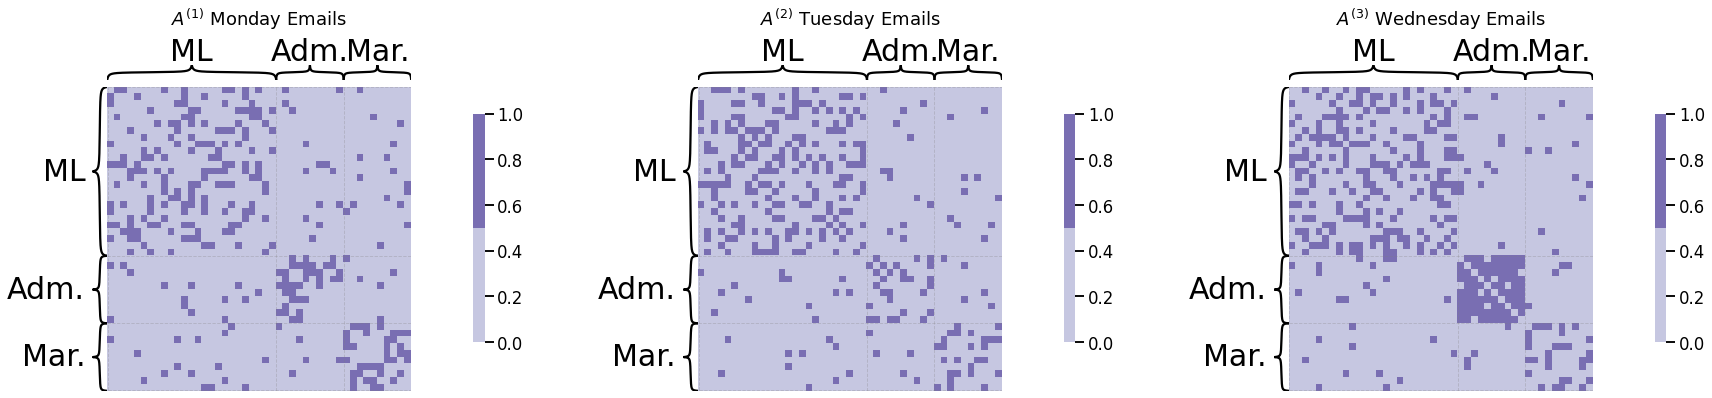

In [44]:
fig

 Remember that for an RDPG random network, the parameter is a latent position matrix, $X^{(m)}$. Let's take a look at the latent position matrix for the random networks that underlie the given realizations:

In [49]:
np.append(0, np.cumsum(ns))

array([ 0, 25, 35, 45])

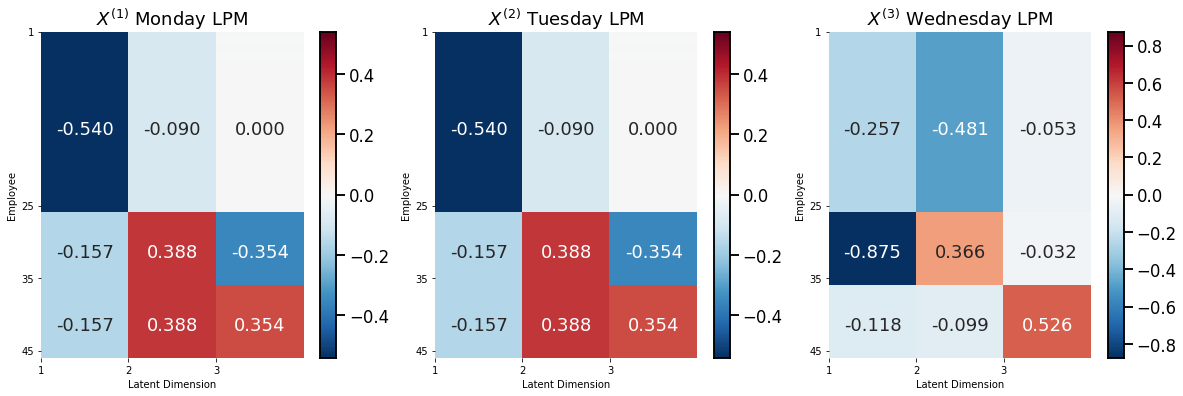

In [100]:
from numpy.linalg import svd
from graphbook_code import cmaps
import seaborn as sns

def p_from_block(B, ns):
    P = np.zeros((np.sum(ns), np.sum(ns)))
    ns_cumsum = np.append(0, np.cumsum(ns))
    for k, n1 in enumerate(ns_cumsum[0:(len(ns_cumsum)-1)]):
        for l, n2 in enumerate(ns_cumsum[k:(len(ns_cumsum)-1)]):
            P[ns_cumsum[k]:ns_cumsum[k+1], ns_cumsum[l+k]:ns_cumsum[l+k+1]] = B[k,l+k]
            P[ns_cumsum[l+k]:ns_cumsum[l+k+1],ns_cumsum[k]:ns_cumsum[k+1]] = B[l+k,k]
    return P

P1 = p_from_block(B1, ns)
U1, S1, V1 = svd(P1)
X1 = U1[:,0:3] @ np.sqrt(np.diag(S1[0:3]))

P2 = p_from_block(B2, ns)
U2, S2, V2 = svd(P2)
X2 = U2[:,0:3] @ np.sqrt(np.diag(S2[0:3]))

P3 = p_from_block(B3, ns)
U3, S3, V3 = svd(P3)
X3 = U3[:,0:3] @ np.sqrt(np.diag(S3[0:3]))

def plot_latent(X, title="", nodename="Employee", ylabel="Latent Dimension",
                nodetix=None, nodelabs=None, ax=None, dimtix=None, dimlabs=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    with sns.plotting_context("talk", font_scale=1):
        lim_max = np.max(np.abs(X))
        vmin = -lim_max; vmax = lim_max
        X_annot = np.empty((45, 3), dtype='U6')
        X_annot[13,0] = str("{:.3f}".format(X[13,0]))
        X_annot[30,0] = str("{:.3f}".format(X[30,0]))
        X_annot[40,0] = str("{:.3f}".format(X[40,0]))
        X_annot[13,1] = str("{:.3f}".format(X[13,1]))
        X_annot[30,1] = str("{:.3f}".format(X[30,1]))
        X_annot[40,1] = str("{:.3f}".format(X[40,1]))
        X_annot[13,2] = str("{:.3f}".format(X[13,2]))
        X_annot[30,2] = str("{:.3f}".format(X[30,2]))
        X_annot[40,2] = str("{:.3f}".format(X[40,2]))
        ax = sns.heatmap(X, cmap=cmaps["divergent"],
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False, vmin=vmin, vmax=vmax,
                        annot=X_annot, fmt='')
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        ax.set(ylabel=nodename, xlabel=ylabel)
        if (nodetix is not None) and (nodelabs is not None):
            ax.set_yticks(nodetix)
            ax.set_yticklabels(nodelabs)
        if (dimtix is not None) and (dimlabs is not None):
            ax.set_xticks(dimtix)
            ax.set_xticklabels(dimlabs)
        cbar.ax.set_frame_on(True)
    return

fig, axs = plt.subplots(1,3, figsize=(20, 6))
plot_latent(X1, nodetix=[0,24,34,44], nodelabs=["1", "25", "35", "45"],
            dimtix=[0,1,2], ax=axs[0], dimlabs=["1", "2", "3"], title="$X^{(1)}$ Monday LPM")
plot_latent(X2, nodetix=[0,24,34,44], nodelabs=["1", "25", "35", "45"],
            dimtix=[0,1,2], ax=axs[1], dimlabs=["1", "2", "3"], title="$X^{(2)}$ Tuesday LPM")
plot_latent(X3, nodetix=[0,24,34,44], nodelabs=["1", "25", "35", "45"],
            dimtix=[0,1,2], ax=axs[2], dimlabs=["1", "2", "3"], title="$X^{(3)}$ Wednesday LPM")

As we can see above, $X^{(1)} = X^{(2)}$, but $X^{(1)}$ and $X^{(2)}$ are not equal to $X^{(3)}$. Since $\mathbf A^{(m)}$ are $RDPG_n(X^{(m)})$, if the latent position matrices for a pair of networks are equal, then the two networks are homogeneous (they have the same marginal distribution). Therefore, the collection of random networks $\left\{\mathbf A^{(1)}, \mathbf A^{(2)}\right\}$ is homogeneous, but the collections $\left\{\mathbf A^{(1)}, \mathbf A^{(3)}\right\}$ and $\left\{\mathbf A^{(2)}, \mathbf A^{(3)}\right\}$ are not homogeneous.

So, unfortunately, we cannot represent our email example using the JRDPG, because the JRDPG cannot handle the hetereogeneity between the random networks of Monday and Tuesday with the random network for Wednesday.

### The Inhomogeous Erdos-Renyi Random Network

To remove this restrictive homogeneity property of the JRDPG, we will need a new single network model, called the Inhomogeneous Erdos-Renyi (IER) random network model. The way we can think of the $IER$ random network is that a probability matrix $P$ with $n$ rows and $n$ columns defines each of the edge-existence probabilities for pairs of nodes in the network. For each pair of nodes $i$ and $j$, we have a unique coin which has a $p_{ij}$ chance of landing on heads, and a $1 - p_{ij}$ chance of laanding on tails. If the coin laands on heads, the edge between nodes $i$ and $j$ exists, and if the coin lands on tails, the edge between nodes $i$ and $j$ does not exist. This coin flip is performed independent of the coin flips for all of the other edges. If $\mathbf A$ is a random network which is $IER$ with a probability matrix $P$, we say that $\mathbf A$ is an $IER_n(P)$ random network.

As before, we can develop a procedure to produce for us a network $A$, which has nodes and edges, where the underlying random network $\mathbf A$ is an $IER_n(P)$ random network:

```{admonition} Simulating a realization from an $IER_n(P)$ random network
1. Determine a probability matrix $P$, whose entries $p_{ij}$ are probabilities.
2. For each pair of nodes $i$ an $j$:
    * Obtain a weighted coin $(i,j)$ which has a probability $p_{ij}$ of landing on heads, and a $1 - p_{ij}$ probability of landing on tails.
    * Flip the $(i,j)$ coin, andd if it lands on heads, the corresponding entry $a_{ij}$ in the adjacency matrix is $1$. If the coin lands on tails, the corresponding entry $a_{ij}$ is $0$. 
3. The adjacency matrix we produce, $A$, is a realization of an $IER_n(P)$ random network. 
```

It is important to realize that all of the networks we have described so far are also $IER_n(P)$ random networks. The previous single network models we have described to date simply place restrictions on the way in which we acquire $P$. For instance, in an $ER_n(p)$ random network, all entries $p_{ij}$ of $P$ are equal to $p$. 

## Common Subspace Independent Edge (COSIE) Model

Unlike the JRDPG model, the Common Subspace Independent Edge (COSIE) model allows for heterogeneity amongst the the $N$ random networks. A **heterogeneous** collection of random networks is a collection of networks $\left\{\mathbf A^{(1)}, ..., \mathbf A^{(N)}\right\}$ is a collection of random networks in which the $N$ networks do not have the same marginal distribution. 

### The COSIE Model is defined by a collection of score matrices and a shared low-rank subspace

For the RDPG, remember that we used the latent position matrix $X$ to define the edge-existence probabilities within the network. Let's imagine that the random network $\mathbf A$ is $RDPG_n(X)$, where $X$ is the latent position matrix. We used the probability matrix, $P$, where $P$ could be defined where $P=XX^\top$. The edge existence probability $p_{ij}$ between a pair of nodes $i$ and $j$ was the inner product $\vec x_i^\top \vec x_j$ of the $i^{th}$ row and the $j^{th}$ row of the latent position matrix $X$. Stated another way, we thought of the edge between a pair of nodes $i$ and $j$ being represented by a coin flip, where the coin had a $\vec x_i^\top \vec x_j$ chance of landing on heads. If the coin lands on heads, an edge exists, and if the coin does not land on heads (with a $1 - \vec x_i^\top \vec x_j$ chance of happening) the edge does not exist. We will use a similar intuition to describe the COSIE model.

Here, we will use a matrix $V$, which is largely similar in intuition to the latent position matrix $X$. The matrix $V$ will have $n$ rows (the number of *nodes* in each of the $N$ networks) and $d$ columns. Like for the RDPG, $d$ will again refer to the latent dimensionality of the collection of random networks. The matrix $V$ has the special property that the $d$ columns of $V$ are **orthonormal**. The matrix $V$ looks like this:
\begin{align*}
    V &= \begin{bmatrix}
        \top & \top & & \top \\
        \vec v_1 & \vec v_2 & ... & \vec v_d \\
        \perp & \perp & & \perp
    \end{bmatrix}
\end{align*}
That $V$ is orthonormal means that, for any column $k$ of the $d$ total columns, that $v_k ^\top v_k = 1$, and for any pair of columns $k$ and $l$ where $k \neq l$, then $v_k^\top v_l = 0$. 

For the COSIE model, we also have a collection of score matrices, $\left\{R^{(1)}, ..., R^{(N)}\right\}$. Each score matrix $R^{(m)}$ is a matrix with $d$ columns and $d$ rows which is symmetric. That $R^{(m)}$ is symmetric means that for any two latent dimensions $k$ and $l$, that $R^{(m)}_{kl} = R^{(m)}_{lk}$.

The way we can think about the COSIE model is that for each random network $m$ of our $N$ total networks, the edges in the $m^{th}$ network depend on the orthonormal matrix $V$ and the score matrix $R^{(m)}$. The probability matrix $P^{(m)}$ for the $m^{th}$ random network is defined so that $P^{(m)} = VR^{(m)}V^\top$. We say that a collection of random networks $\left\{\mathbf A^{(1)}, ..., \mathbf A^{(N)}\right\}$ with $n$ nodes is $COSIE_n\left(V, \left\{R^{(1)},...,R^{(N)}\right\}\right)$ if each random network $\mathbf A^{(m)}$ is $IER(P^{(m)})$. Stated another way, each of the $N$ random networks share the same orthonormal matrix $V$, but a unique score matrix $R^{(m)}$. This allows the random networks to share some underlying structure (which is conveyed by $V$) but each random network still has a combination of this shared structure (conveyed by $R^{(m)}$). 